In [1]:
import networkx as nx
import csv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import gc
%matplotlib inline

Reading graph edges and nodes:

In [35]:
with open('../csv_files/metro_edges_no_duplicated_edges_no_cycles_speed_networkx.csv') as f:
    f.readline()
    # Source,Target,Weight,edge_name,edge_color,travel_seconds,longitude_Source,latitude_Source,longitude_Target,latitude_Target,distance_meters,speed_ms
    g = nx.parse_edgelist(f, delimiter=',', nodetype=int, data=(('Weight', float), ('edge_name', str), ('edge_color', str), ('travel_seconds', float), ('longitude_Source', float), ('latitude_Source', float), ('longitude_Target', float), ('latitude_Target', float), ('distance_meters', float), ('speed_ms', float) ), create_using = nx.MultiGraph())
    
with open('../csv_files/metro_gephi_nodes_coordinates.csv') as f:
    reader = csv.DictReader(f)

    node_latitudes = {}
    node_longitudes = {}
    node_names = {}
    
    for row in reader:
        node_latitudes[ int(row['Id']) ] = float(row['latitude'])
        node_longitudes[ int(row['Id']) ] = float(row['longitude'])
        node_names[ int(row['Id']) ] = row['Label']
        
nx.set_node_attributes(g, name = 'latitude', values = node_latitudes)
nx.set_node_attributes(g, name = 'longitude', values = node_longitudes)
nx.set_node_attributes(g, name = 'name', values = node_names)

In [4]:
def top_n_stations_by_attribute(graph, attr_name, n, ascending = False):
    return pd.DataFrame.from_records(map(lambda x: x[1], list(graph.nodes(data=True)) ))[['name', attr_name]].sort_values(attr_name, ascending = ascending)[:(n+1)].reset_index(drop=True).shift()[1:]

Top 35 stations with more neighbour stations 

In [104]:
nx.set_node_attributes(g, name = 'degree', values = dict(g.degree))

stations_and_their_neighbours = top_n_stations_by_attribute(g, 'degree', len(g.edges()))

stations_and_their_neighbours[:35]

,name,degree
1,AVENIDA DE AMERICA,8.0
2,PLAZA DE CASTILLA,6.0
3,ALONSO MARTINEZ,6.0
4,SOL,6.0
5,DIEGO DE LEON,6.0
6,OPERA,5.0
7,PRINCIPE PIO,5.0
8,ARGÜELLES,5.0
9,NUEVOS MINISTERIOS,5.0
10,CUATRO CAMINOS,5.0


Neighbours' count histogram

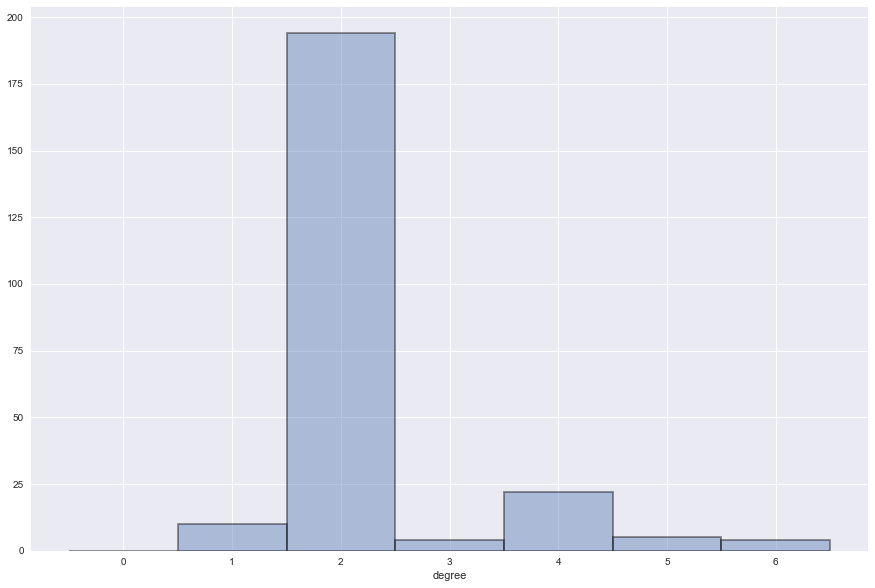

In [105]:
sns.plt.figure(figsize=(15, 10))
sns.distplot(stations_and_their_neighbours['degree'], kde=False, rug=False, bins = np.arange(8)-0.5, hist_kws=dict(edgecolor='k', linewidth=2))
sns.plt.show()

In [106]:
stations_and_their_neighbours.groupby('degree').count().rename(columns={'name': 'count'})

,count
degree,
1.0,10
2.0,194
3.0,4
4.0,22
5.0,5
6.0,4
8.0,1


Most of the stations are connected to two other stations. 

There are 10 Metro stations which are connected to only 1 stations: these stations are the most vulnerable because they strongly depend on other stations to remain connected to the Madrid Metro network.

Calculating stations importance using Closeness Centrality: This metric indicates how long it will take for information (people) from a node (station) "u" will take to reach other nodes (stations) in the network. We can determine which is the closest node (station) to any other node (station) in the network.

In [107]:
nx.set_node_attributes(g, name = 'closeness_centrality', values = nx.closeness_centrality(g, distance = 'travel_seconds'))

Top 20 most important (according to Closeness Centrality algorithm) Metro stations are shown

In [108]:
top_n_stations_by_attribute(g, 'closeness_centrality', 20)

,name,closeness_centrality
1,GREGORIO MARAÑON,0.000384
2,ALONSO MARTINEZ,0.000383
3,TRIBUNAL,0.000376
4,AVENIDA DE AMERICA,0.000374
5,PLAZA DE ESPAÑA,0.000369
6,NUÑEZ DE BALBOA,0.000367
7,NUEVOS MINISTERIOS,0.000367
8,RUBEN DARIO,0.000366
9,BILBAO,0.000365
10,DIEGO DE LEON,0.000364


Another metric to have in mind: Betweenness Centrality. This metric indicates how often a node (station) is found on a shortest path between two nodes (stations) in the network.

In [109]:
nx.set_node_attributes(g, name = 'betweenness_centrality', values = nx.betweenness_centrality(g, normalized = True, weight = 'Weight'))

Top 20 most important (according to Betweenness Centrality algorithm) Metro stations are shown

In [110]:
top_n_stations_by_attribute(g, 'betweenness_centrality', 20)

,name,betweenness_centrality
1,GREGORIO MARAÑON,0.321421
2,PRINCIPE PIO,0.311290
3,NUEVOS MINISTERIOS,0.305922
4,ALONSO MARTINEZ,0.296078
5,AVENIDA DE AMERICA,0.281850
6,CASA DE CAMPO,0.255851
7,LAGO,0.246326
8,BATAN,0.240864
9,TRIBUNAL,0.230387
10,COLONIA JARDIN,0.225907


It seems Gregorio Marañón is quite important again, and thanks to the Betweenness Centrality we can say Gregorio Marañón is the Metro station that controls the most the Metro network because more information (people) can pass through it than on any other node (station).

Now let's calculate the articulation points: a node (Metro Station) is an articulation point if the graph gets disconnected (some Metro Stations will stop being connected somehow to other Metro Stations) by removing that node (station).

In [111]:
dict_nodes = g.node_dict_factory(g.nodes)

In [112]:
articulation_stations = list(nx.articulation_points(nx.Graph(g)))

print('%i articulation stations out of %i stations (%0.3f %%) \n' % (len(articulation_stations), len(dict_nodes.keys()), (len(articulation_stations) * 100)/len(dict_nodes.keys()) ) )
aux_list = []
for i in articulation_stations:
    aux_list.append(dict_nodes[i]['name'])
    
aux_list.sort()
aux_list

96 articulation stations out of 241 stations (39.834 %) 



['ABRANTES',
 'AEROPUERTO T1 T2 T3',
 'ALMENDRALES',
 'ALSACIA',
 'ALTO DEL ARENAL',
 'ANTONIO MACHADO',
 'ARTILLEROS',
 'ASCAO',
 'AVDA. DE LA ILUSTRACION',
 'AVENIDA DE GUADALAJARA',
 'AVIACION ESPAÑOLA',
 'BARAJAS',
 'BARRIO DEL PILAR',
 'BARRIO DEL PUERTO',
 'BAUNATAL',
 'BEGOÑA',
 'BUENOS AIRES',
 'CANILLEJAS',
 'CARABANCHEL ALTO',
 'CASA DE CAMPO',
 'CHAMARTIN',
 'CIUDAD DE LOS ANGELES',
 'CIUDAD LINEAL',
 'COLONIA JARDIN',
 'CONGOSTO',
 'COSLADA CENTRAL',
 'CUATRO VIENTOS',
 'EL CAPRICHO',
 'ESTADIO METROPOLITANO',
 'ESTRELLA',
 'FERIA DE MADRID',
 'FRANCOS RODRIGUEZ',
 'FUENCARRAL',
 'GARCIA NOBLEJAS',
 'GUZMAN EL BUENO',
 'HENARES',
 'HERRERA ORIA',
 'HOSPITAL 12 DE OCTUBRE',
 'JARAMA',
 'JOAQUIN VILUMBRALES',
 'LA ALMUDENA',
 'LA ELIPA',
 'LA GAVIA',
 'LA GRANJA',
 'LA MORALEJA',
 'LA PESETA',
 'LA POVEDA',
 'LA RAMBLA',
 'LACOMA',
 'LAS MUSAS',
 'LAS SUERTES',
 'LAS TABLAS',
 'LEGAZPI',
 'MANUEL DE FALLA',
 'MAR DE CRISTAL',
 'MARQUES DE LA VALDAVIA',
 'MIGUEL HERNANDEZ',
 '

As you can see that was a long list. However, there are Metro Stations which are more critical than others. For example, if Puerta del Sur would stop working, none of the Metro Sur (Line 12) stations could reach any Madrid Metro Station because Puerta del Sur is the only one station that connects the Line 12 with the rest of the Metro network.

So in order to know which articulation stations are the most critical, I'm gonna count the number of connected components (the sets of connected Metro Stations) and the number of nodes (stations) each component has.

In [113]:
art_points_dict = {}

for i in articulation_stations:
    g_copy = g.copy()
    
    g_copy.remove_node(i)
    
    art_points_dict[dict_nodes[i]['name']] = {'n_ccs': nx.number_connected_components(g_copy)}
#     print(dict_nodes[i]['name'])
#     print('')
#     print('Connected components if that node (station) is removed: %i' % art_points_dict[dict_nodes[i]['name']]['n_ccs'])
    cc_i = 1
    n_nodes_ccs = []
    for cc in nx.connected_components(g_copy): 
        art_points_dict[dict_nodes[i]['name']]['nodes_cc_' + str(cc_i)] = len(cc)
#         print('Nodes (stations) in connected component %i: %i' % (cc_i, art_points_dict[dict_nodes[i]['name']]['nodes_cc_' + str(cc_i)]))        
        n_nodes_ccs.append(art_points_dict[dict_nodes[i]['name']]['nodes_cc_' + str(cc_i)])
        cc_i += 1
        
    n_nodes_ccs.sort(reverse = True)
    art_points_dict[dict_nodes[i]['name']]['n_isolated_nodes'] = sum(n_nodes_ccs[1:])
    
#     print('Number of isolated nodes (stations): %i' % art_points_dict[dict_nodes[i]['name']]['n_isolated_nodes'])
        
#     print('-------------------------------------------------------------------------------------------')
    
    del g_copy
    gc.collect()

In [114]:
art_points_info_df = pd.DataFrame.from_dict(art_points_dict, orient='index')[['n_ccs', 'n_isolated_nodes', 'nodes_cc_1', 'nodes_cc_2', 'nodes_cc_3']] 

Top 20 most critical articulation Metro stations:

In [115]:
art_points_info_df.sort_values('n_isolated_nodes', ascending = False)[:20]

,n_ccs,n_isolated_nodes,nodes_cc_1,nodes_cc_2,nodes_cc_3
CASA DE CAMPO,2,32,208,32,NaN
COLONIA JARDIN,2,31,209,31,NaN
AVIACION ESPAÑOLA,2,30,210,30,NaN
CUATRO VIENTOS,2,29,211,29,NaN
JOAQUIN VILUMBRALES,2,28,212,28,NaN
PUERTA DEL SUR,2,27,213,27,NaN
PUEBLO NUEVO,3,19,221,6,13.0
SAINZ DE BARANDA,2,13,227,13,NaN
CHAMARTIN,2,13,227,13,NaN
PACIFICO,2,12,228,12,NaN


As you can see, Casa de Campo is the most critical Metro Station because removing it...
* Would leave the whole Metro Sur network disconnected from the Madrid Metro network
* If we had into accont Metro Ligero stations, the rest of Madrid Metro network couldn't reach any Metro Ligero station since Casa de Campo is the only one connection.
* Joaquín Vilumbrales, Cuatro Vientos, Aviación Española and Colonia Jardín would get disconnected from the rest of the Madrid Metro network too.
* Without taking into account Metro Ligero stations, Móstoles, Alcorcón, Fuenlabrada, Getafe and Leganés would get disconnected from Madrid via Metro (cities/towns would get disconnected from Madrid).

Of course, any station between Cuatro Vientos and Puerta del Sur (both included) are extremely critical and would had similar effects of those written above.

Pueblo Nuevo is another critical station to have in mind, since is the only one that connects 6 Line 5 stations (Ciudad Lineal, Suanzes, Torre Arias, Canillejas, El Capricho and Alameda Osuna) and 13 Line 7 stations (Ascao, García Noblejas, Simancas, San Blas, Las Musas, Estadio Metropolitano, Barrio del Puerto, La Rambla, San Fernando, Jarama, Henares and Hospital del Henares) to the rest of the Madrid Metro network. Line 7 connects Madrid with Coslada and San Fernando de Henares, so again cities would get disconnected from Madrid. Pueblo Nuevo case is special because it generates 3 connected componets.

Similar conclusions can be drawn in the cases of Sainz de Baranda and Chamartín: again there would be a disconnection between Madrid and other towns (not to mention many Madrid wards would get disconnected from the resto of Madrid Metro network too).

Though Plaza Elíptica doesn't appear on the Top 20 list, it's a critical station too because it's the only station that connects Line 11 with the rest of Madrid Metro network.

My final conclusion on this topic is that towns and cities (some Madrid wards too, specially those in the most outer Madrid areas) are very weakly connected to the rest of the Metro network having many critical unique points of failure.

Eigenvector centrality: a node (station) importance is based on how important its neighbours are.

In [223]:
nx.set_node_attributes(g, name = 'eigenvector_centrality', values = nx.eigenvector_centrality_numpy(g, weight = 'Weight', max_iter = 1000))

Top 20 most important Metro stations based on Eigenvector Centrality.

In [224]:
top_n_stations_by_attribute(g, 'eigenvector_centrality', 20)

,name,eigenvector_centrality
1,AVENIDA DE AMERICA,0.465889
2,DIEGO DE LEON,0.453658
3,NUÑEZ DE BALBOA,0.270761
4,MANUEL BECERRA,0.215611
5,ALONSO MARTINEZ,0.182170
6,GREGORIO MARAÑON,0.182113
7,VENTAS,0.171162
8,LISTA,0.160603
9,CALLAO,0.156859
10,SOL,0.154792


This looks interesting: as you can see, Gregorio Marañón is not the most important station according to this centrality measure. Avenida América it's important persé and it's connected to other important stations like Diego de León (2th position), Núñez de Balboa (3th position), Manuel Becerra (4th position) and Gregorio Marañón (6th position).

I can see there are two important stations in different areas: one is Avenida América and the other one is Alonso Martínez, many Metro lines pass through those stations (lines 6, 4, 7 and 9 pass through Avenida América and lines 10, 5 and 4 pass through Alonso Martinez). Both stations are connected by Gregorio Marañón.

Though the data doesn't take this into account, Noviciado and Plaza España are connected underground: the problem is they aren't directly connected by railways, you need to walk through the stations. So we could think about Plaza España and Noviciado as an important unique station that joins up to 3 lines (line 2, line 3 and line 10).

Let's get some info about edges speeds and distances:

In [36]:
aux_edges_dict = {}

i = 0
for edge in list(g.edges(data = True)):
    edge[2]['Source'] = node_names[edge[0]]
    edge[2]['Target'] = node_names[edge[1]]
    aux_edges_dict[i] = edge[2]
    i += 1
    
edges_pd = pd.DataFrame.from_dict(aux_edges_dict, orient='index')[['Source', 'Target', 'edge_name', 'distance_meters', 'travel_seconds', 'speed_ms', 'Weight', 'edge_color', 'longitude_Source', 'latitude_Source', 'longitude_Target', 'latitude_Target']]

Top 20 further edges (connections between stations)

In [38]:
edges_pd.sort_values('distance_meters', ascending = False)[:20]

,Source,Target,edge_name,distance_meters,travel_seconds,speed_ms,Weight,edge_color,longitude_Source,latitude_Source,longitude_Target,latitude_Target
196,PUERTA DE ARGANDA,RIVAS URBANIZACIONES,9,5640.865434,656.0,8.598880,0.001524,A60084,-3.59598,40.40132,-3.54728,40.36677
181,FERIA DE MADRID,AEROPUERTO T1 T2 T3,8,3992.241735,492.0,8.114312,0.002033,EC82B1,-3.61620,40.46389,-3.56954,40.46864
198,RIVAS VACIAMADRID,LA POVEDA,9,3811.419717,573.0,6.651692,0.001745,A60084,-3.47745,40.31902,-3.52060,40.32837
197,RIVAS URBANIZACIONES,RIVAS FUTURA,9,3409.393651,522.0,6.531405,0.001916,A60084,-3.52479,40.34134,-3.54728,40.36677
208,CUATRO VIENTOS,JOAQUIN VILUMBRALES,10,3368.128567,535.0,6.295567,0.001869,005AA9,-3.79152,40.37771,-3.80720,40.34985
211,PUERTA DEL SUR,SAN NICASIO,12,3240.105573,317.0,10.221153,0.003155,A49800,-3.81211,40.34524,-3.77587,40.33616
200,LA POVEDA,ARGANDA DEL REY,9,3062.375720,533.0,5.745545,0.001876,A60084,-3.47745,40.31902,-3.44752,40.30367
265,ESTADIO METROPOLITANO,BARRIO DEL PUERTO,7,2892.155719,608.0,4.756835,0.001645,EE7518,-3.60015,40.43339,-3.56919,40.42250
179,COLOMBIA,PINAR DEL REY,8,2716.031916,402.0,6.756298,0.002488,EC82B1,-3.67682,40.45634,-3.64867,40.46800
221,MANUELA MALASAÑA,LORANCA,12,2618.338612,494.0,5.300281,0.002024,A49800,-3.86402,40.30903,-3.83768,40.29681


Top 20 closest edges (connections between stations)

In [39]:
edges_pd.sort_values('distance_meters')[:20]

,Source,Target,edge_name,distance_meters,travel_seconds,speed_ms,Weight,edge_color,longitude_Source,latitude_Source,longitude_Target,latitude_Target
18,BILBAO,SAN BERNARDO,4,306.395820,213.0,1.438478,0.004695,B65518,-3.70218,40.42906,-3.70557,40.43001
92,SERRANO,VELAZQUEZ,4,317.955028,209.0,1.521316,0.004785,B65518,-3.68663,40.42543,-3.68292,40.42503
22,GRAN VIA,CALLAO,5,327.909468,215.0,1.525160,0.004651,8FD400,-3.70566,40.42014,-3.70180,40.42001
17,BILBAO,TRIBUNAL,1,331.608956,269.0,1.232747,0.003717,2DBEF0,-3.70218,40.42906,-3.70110,40.42619
77,DELICIAS,PALOS DE LA FRONTERA,3,352.013487,218.0,1.614741,0.004587,FFD000,-3.69423,40.40307,-3.69420,40.39990
32,ATOCHA,ATOCHA-RENFE,1,364.237439,243.0,1.498920,0.004115,2DBEF0,-3.69249,40.40885,-3.68938,40.40659
26,SOL,SEVILLA,2,364.289816,200.0,1.821449,0.005000,ED1C24,-3.69925,40.41805,-3.70326,40.41688
23,GRAN VIA,SOL,1,368.990941,245.0,1.506085,0.004082,2DBEF0,-3.70180,40.42001,-3.70326,40.41688
67,SAN BERNARDO,QUEVEDO,2,371.653102,191.0,1.945828,0.005236,ED1C24,-3.70557,40.43001,-3.70433,40.43322
91,COLON,SERRANO,4,371.695283,230.0,1.616066,0.004348,B65518,-3.68663,40.42543,-3.69101,40.42542


In [79]:
edges_dist_grouped = edges_pd[['edge_name', 'distance_meters']].groupby(by = 'edge_name').describe().iloc[[0, 4, 5, 6, 7, 8, 9, 10, 11, 1, 2, 3, 12],:]
edges_dist_grouped['distance_meters'].sort_values('mean', ascending = False)

,count,mean,std,min,25%,50%,75%,max
edge_name,,,,,,,,
8,7.0,2090.554160,1012.626402,892.001535,1531.809875,1974.282182,2355.866960,3992.241735
12,28.0,1308.175857,647.051661,688.576920,913.412813,1068.429811,1248.166272,3240.105573
9,28.0,1305.867872,1197.888734,521.874851,734.917837,852.736464,1136.665113,5640.865434
10,30.0,1196.303907,603.975131,452.139405,823.668233,998.498537,1395.535527,3368.128567
11,6.0,1023.297599,481.567731,488.703237,802.324197,936.687495,1067.317455,1909.310159
R,1.0,982.474455,NaN,982.474455,982.474455,982.474455,982.474455,982.474455
7,29.0,856.971367,447.237946,407.781924,644.993945,778.963681,931.551413,2892.155719
6,28.0,807.836514,201.114395,398.674236,690.055645,776.155292,955.202393,1134.044482
3,17.0,770.150140,338.648770,352.013487,451.634963,752.897124,973.579449,1598.601497


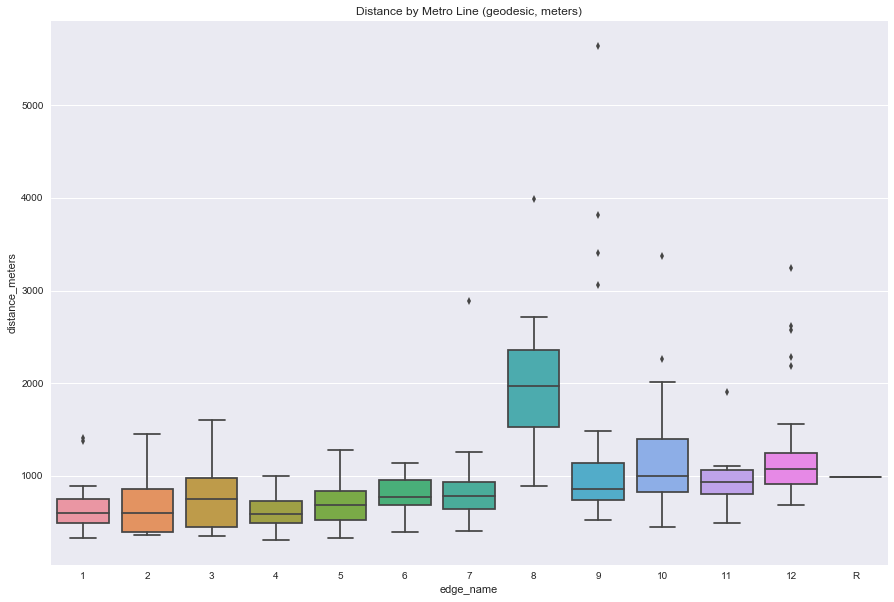

In [56]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=edges_pd, x = 'edge_name', y = 'distance_meters', order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 'R']).set_title('Distance by Metro Line (geodesic, meters)')
plt.show()

Mean distance per edge (stations connections) per line

In [77]:
edges_dist_grouped = edges_dist_grouped.assign(dist_per_edge = edges_dist_grouped['distance_meters']['mean'] / (edges_dist_grouped['distance_meters']['count'] - 1) )
edges_dist_grouped = edges_dist_grouped.assign(dist_per_edge_std = edges_dist_grouped['distance_meters']['std'] / (edges_dist_grouped['distance_meters']['count'] - 1) )
edges_dist_grouped.sort_values('dist_per_edge', ascending = False).iloc[1:,:] # I removed the first line because it was useless (R line, only two stations)

distance_meters                                                     \
                    count         mean          std         min          25%   
edge_name                                                                      
8                     7.0  2090.554160  1012.626402  892.001535  1531.809875   
11                    6.0  1023.297599   481.567731  488.703237   802.324197   
12                   28.0  1308.175857   647.051661  688.576920   913.412813   
9                    28.0  1305.867872  1197.888734  521.874851   734.917837   
3                    17.0   770.150140   338.648770  352.013487   451.634963   
10                   30.0  1196.303907   603.975131  452.139405   823.668233   
2                    19.0   688.115018   318.001062  364.289816   396.528806   
7                    29.0   856.971367   447.237946  407.781924   644.993945   
6                    28.0   807.836514   201.114395  398.674236   690.055645   
4                    22.0   617.701692   199.764084  306.395820   491.979808   
5                    31.0   698.599916   233.507344  327.909468   520.261183   
1                    32.0   645.793039   250.922358  331.608956   493.155046   

                                                 dist_per_edge  \
                   50%          75%          max                 
edge_name                                                        
8          1974.282182  2355.866960  3992.241735    348.425693   
11          936.687495  1067.317455  1909.310159    204.659520   
12         1068.429811  1248.166272  3240.105573     48.450958   
9           852.736464  1136.665113  5640.865434     48.365477   
3           752.897124   973.579449  1598.601497     48.134384   
10          998.498537  1395.535527  3368.128567     41.251859   
2           595.169517   854.392727  1452.072937     38.228612   
7           778.963681   931.551413  2892.155719     30.606120   
6           776.155292   955.202393  1134.044482     29.919871   
4           583.518703   729.953542   992.863412     29.414366   
5           680.924522   838.516313  1281.811521     23.286664   
1           603.481091   754.733699  1413.201461     20.832034   

          dist_per_edge_std  
                             
edge_name                    
8                168.771067  
11                96.313546  
12                23.964876  
9                 44.366249  
3                 21.165548  
10                20.826729  
2                 17.666726  
7                 15.972784  
6                  7.448681  
4                  9.512575  
5                  7.783578  
1                  8.094270

It's clear line 8 is the line with the highest mean distance between stations. 

To have in mind the number of stations and the variability of the values, I plotted a box-plot and calculated the mean distance between stations by edge (a pair of stations connected).

This last part reveals that line 8 is again the line whose stations are further from each other. We can find line 11 in the second place, with a mean distance per edge (pair of connected stations) of 204.66 meters (+/- 168.77 meters).